In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os

import fbprophet

from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


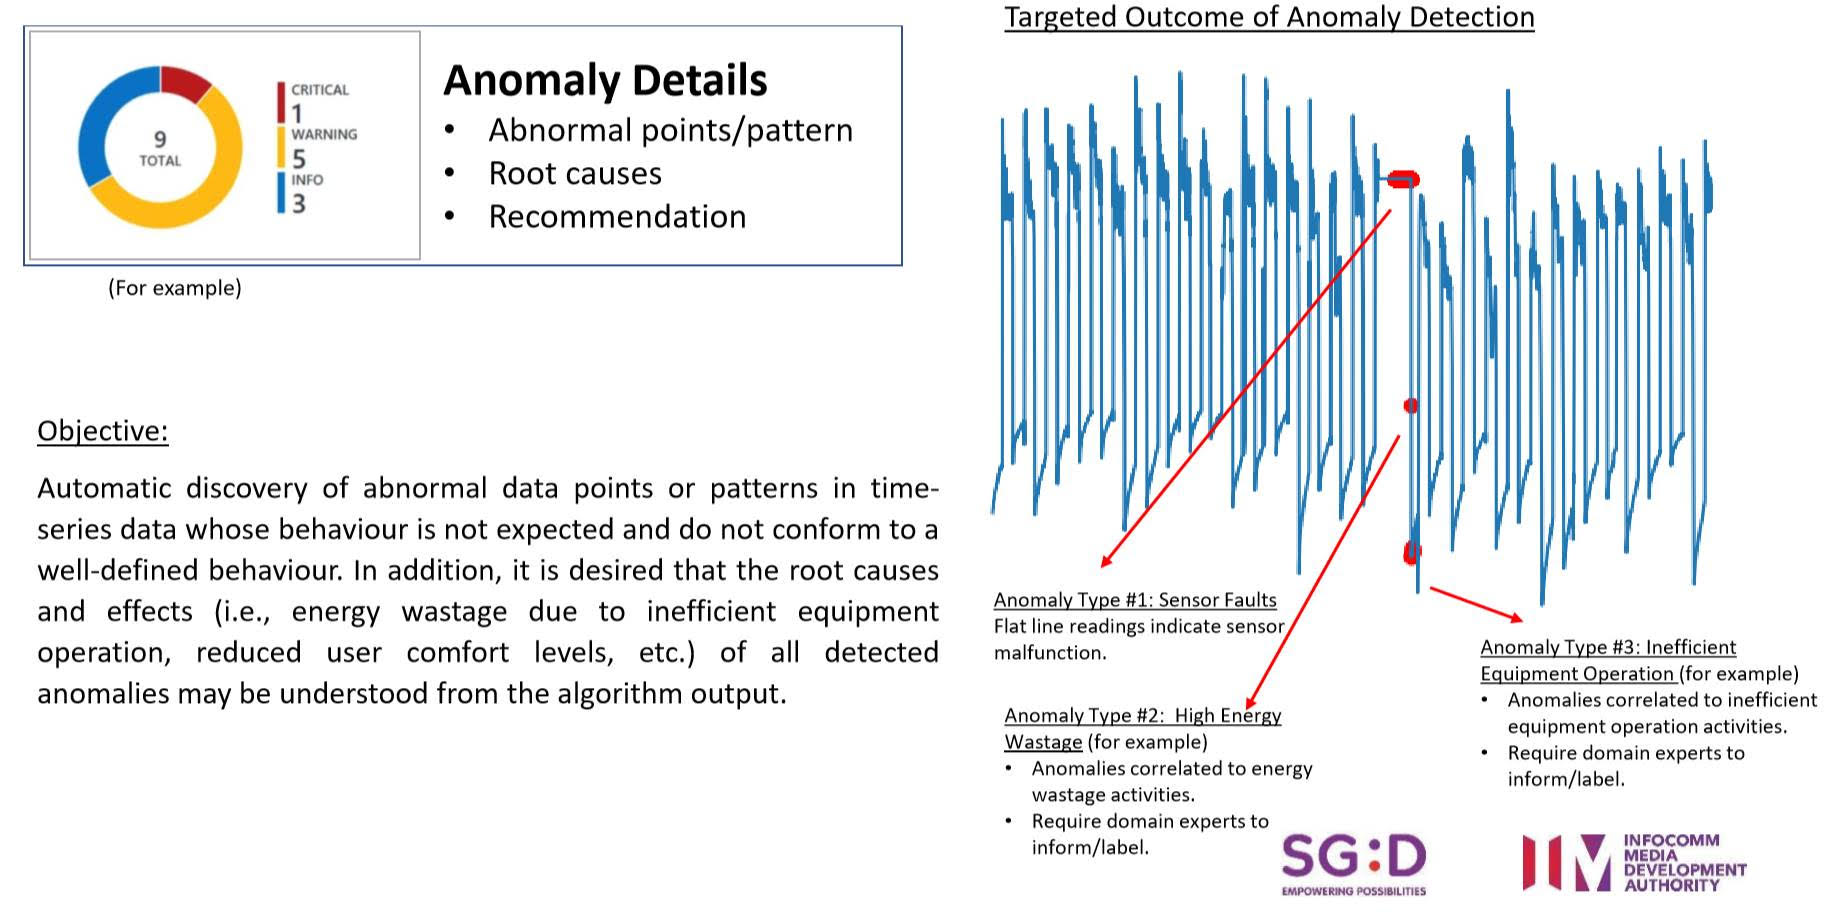

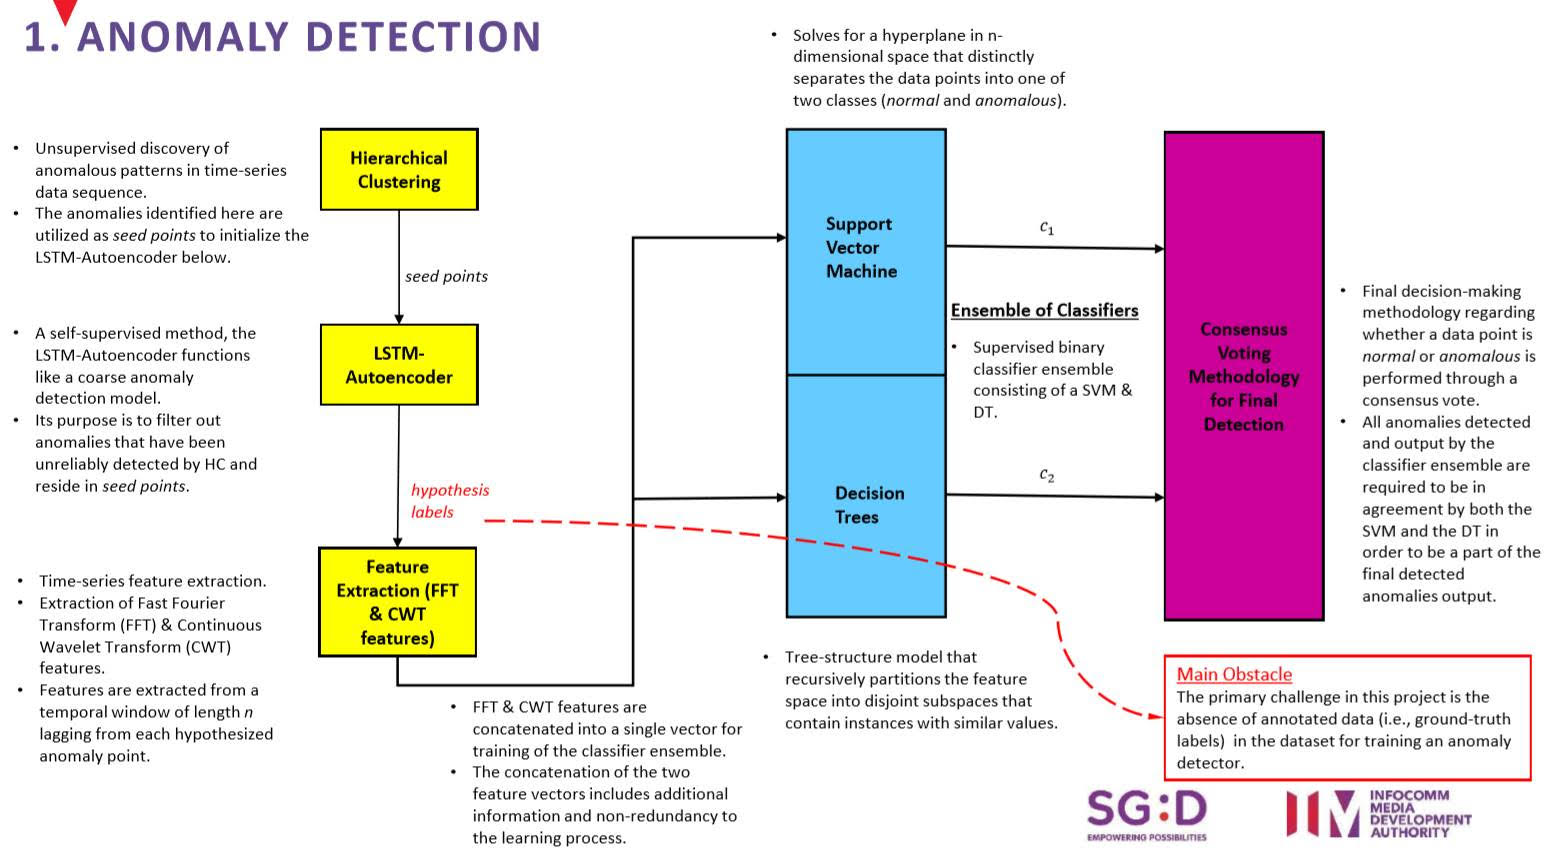

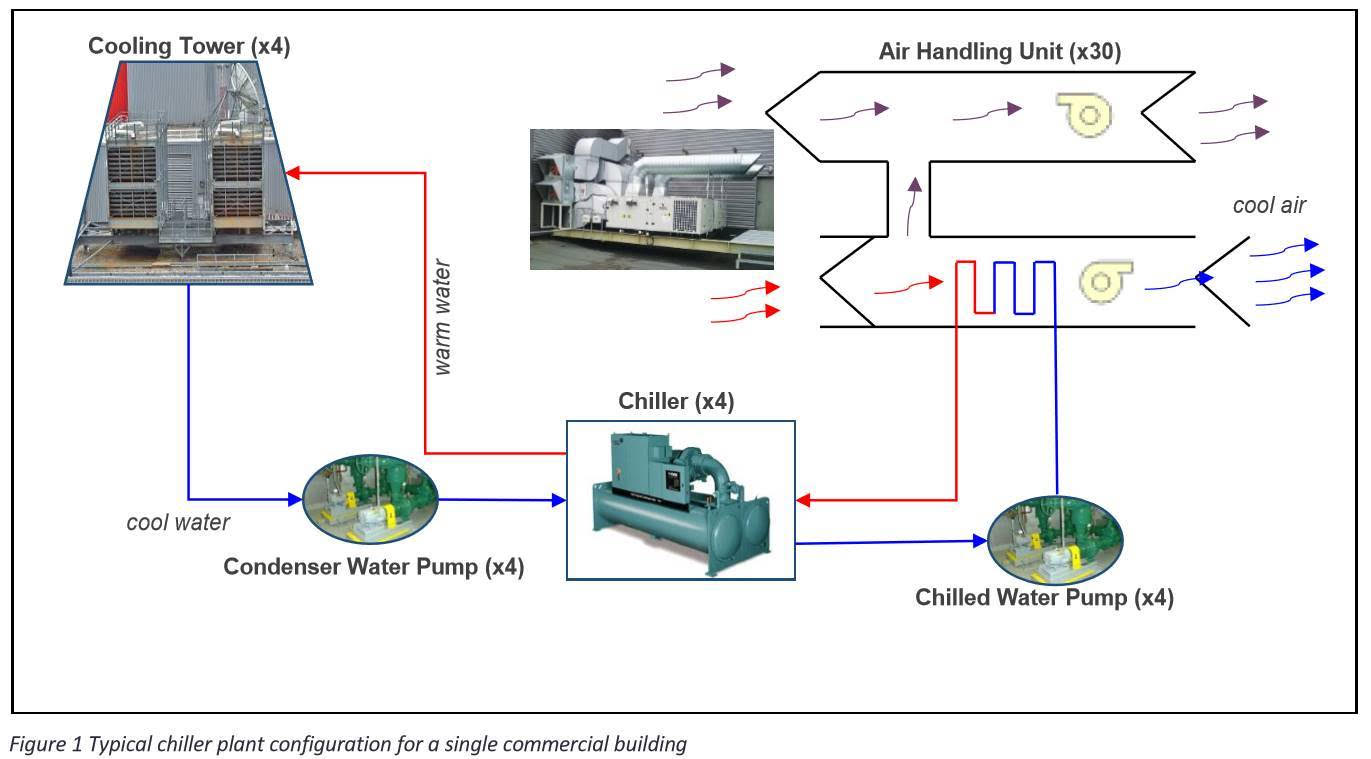
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

## Read Data

In [2]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
derivecol = ['(CWRT_syth)-(HLI Entering CHW Temp)']
timecols=['weekday', 'hourminute']

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

#### data_2_clean

In [3]:
data_2_clean = pd.read_csv(rootPath+'data_2_clean.csv', 
                          index_col='Unnamed: 0', date_parser=dateparse)
# create additional features
data_2_clean['(CWRT_syth)-(HLI Entering CHW Temp)'] = \
    data_2_clean['CWRT_syth']-data_2_clean['HLI Entering CHW Temp']


print(data_2_clean.shape)
print(data_2_clean.dtypes)
print(min(data_2_clean.index), max(data_2_clean.index))
display(data_2_clean.head())


(17719, 5)
CWRT_syth                              float64
HLI Entering CHW Temp                  float64
weekday                                  int64
hourminute                               int64
(CWRT_syth)-(HLI Entering CHW Temp)    float64
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


CWRT_syth  HLI Entering CHW Temp  weekday  hourminute  \
2019-01-13 00:00:00  30.490000              11.700000        7           0   
2019-01-13 00:05:00  30.506000              11.125000        7           5   
2019-01-13 00:10:00  30.530001              10.600000        7          10   
2019-01-13 00:15:00  30.546000              10.633334        7          15   
2019-01-13 00:20:00  30.590000              10.666667        7          20   

                     (CWRT_syth)-(HLI Entering CHW Temp)  
2019-01-13 00:00:00                            18.790000  
2019-01-13 00:05:00                            19.381000  
2019-01-13 00:10:00                            19.930000  
2019-01-13 00:15:00                            19.912667  
2019-01-13 00:20:00                            19.923333

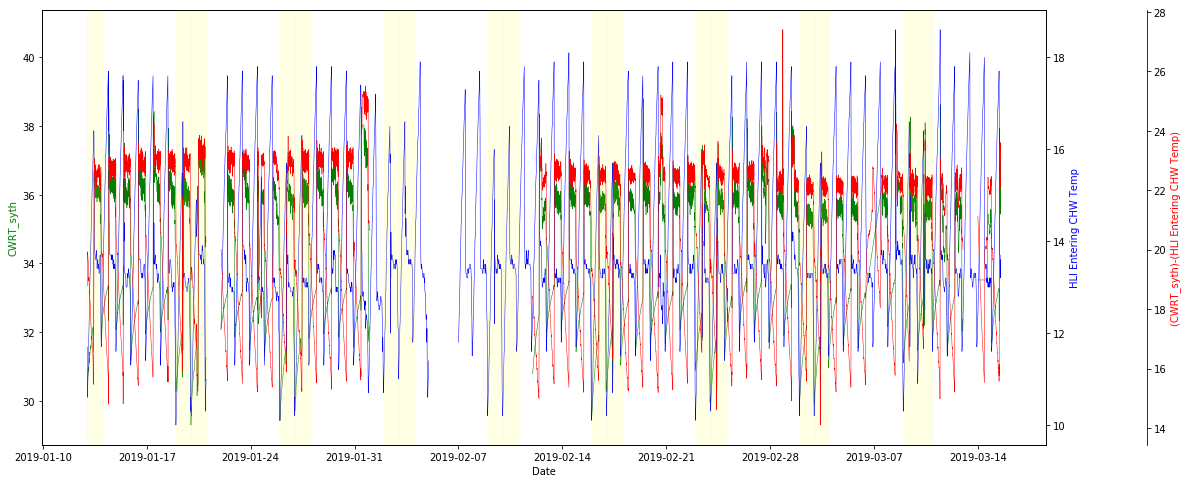

In [4]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_2_clean.index, data_2_clean[c], c=clr[0], 
                  markersize=0.5, marker='', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2_clean.index.to_frame()
tmp['wkday'] = data_2_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


#### data_3

In [5]:
data_3 = pd.read_csv(rootPath+'data_3_prophet.csv', index_col='Unnamed: 0', date_parser=dateparse)

print(data_3.shape)
print(data_3.dtypes)
print(min(data_3.index), max(data_3.index))
display(data_3.head())


(17719, 18)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                   bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)       bool
weekday                                        int64
hourminute                                     int64
Score_(CWRT_syth)_distanced                  float64
Score_(HLI Entering CHW Temp)_distanced      float64
Score_(CWRT_syth)_cluster                    float64
Score_(HLI Entering CHW Temp)_cluster        float64
(CWRT_syth)-(HLI Entering CHW Temp)          float64
CWRT_syth_pred                               float64
CWRT_syth_pred_lower                         float64
CWRT_syth_pred_upper                         float64
Score_(CWRT_syth)_fb                         float64
Score_(CWRT_syth)_fb_modified                float64
dtype: object
2019-01-13 00:00:00 

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  weekday  \
2019-01-13 00:00:00                                      False        7   
2019-01-13 00:05:00                                      False        7   
2019-01-13 00:10:00                                      False        7   
2019-01-13 00:15:00                                      False        7   
2019-01-13 00:20:00                                      False        7   

                     hourminute  Score_(CWRT_syth)_distanced  \
2019-01-13 00:00:00           0                          0.0   
2019-01-13 00:05:00           5                          0.0   
2019-01-13 00:10:00          10                          0.0   
2019-01-13 00:15:00          15                          0.0   
2019-01-13 00:20:00          20                          0.0   

                     Score_(HLI Entering CHW Temp)_distanced  \
2019-01-13 00:00:00                                      NaN   
2019-01-13 00:05:00                                      NaN   
2019-01-13 00:10:00                                      0.0   
2019-01-13 00:15:00                                      NaN   
2019-01-13 00:20:00                                      NaN   

                     Score_(CWRT_syth)_cluster  \
2019-01-13 00:00:00                  27.467759   
2019-01-13 00:05:00                  27.467759   
2019-01-13 00:10:00                  27.467759   
2019-01-13 00:15:00                  27.467759   
2019-01-13 00:20:00                  27.467759   

                     Score_(HLI Entering CHW Temp)_cluster  \
2019-01-13 00:00:00                                2.62796   
2019-01-13 00:05:00                                2.62796   
2019-01-13 00:10:00                                2.62796   
2019-01-13 00:15:00                                2.62796   
2019-01-13 00:20:00                                2.62796   

                     (CWRT_syth)-(HLI Entering CHW Temp)  CWRT_syth_pred  \
2019-01-13 00:00:00                                  NaN       31.078512   
2019-01-13 00:05:00                                  NaN       31.050151   
2019-01-13 00:10:00                            20.529999       31.026189   
2019-01-13 00:15:00                                  NaN       31.006549   
2019-01-13 00:20:00                                  NaN       30.991137   

                     CWRT_syth_pred_lower  CWRT_syth_pred_upper  \
2019-01-13 00:00:00             28.673261             33.290644   
2019-01-13 00:05:00             28.829544             33.309947   
2019-01-13 00:10:00             28.664084             33.169350   
2019-01-13 00:15:00             28.609239             33.432040   
2019-01-13 00:20:00             28.535493             33.063928   

                     Score_(CWRT_syth)_fb  Score_(CWRT_syth)_fb_modified  
2019-01-13 00:00:00              0.035330                       0.035330  
2019-01-13 00:05:00              0.171865                       0.171865  
2019-01-13 00:10:00              0.319480                       0.319480  
2019-01-13 00:15:00              0.429174                       0.429174  
2019-01-13 00:20:00              0.550475                       0.550475

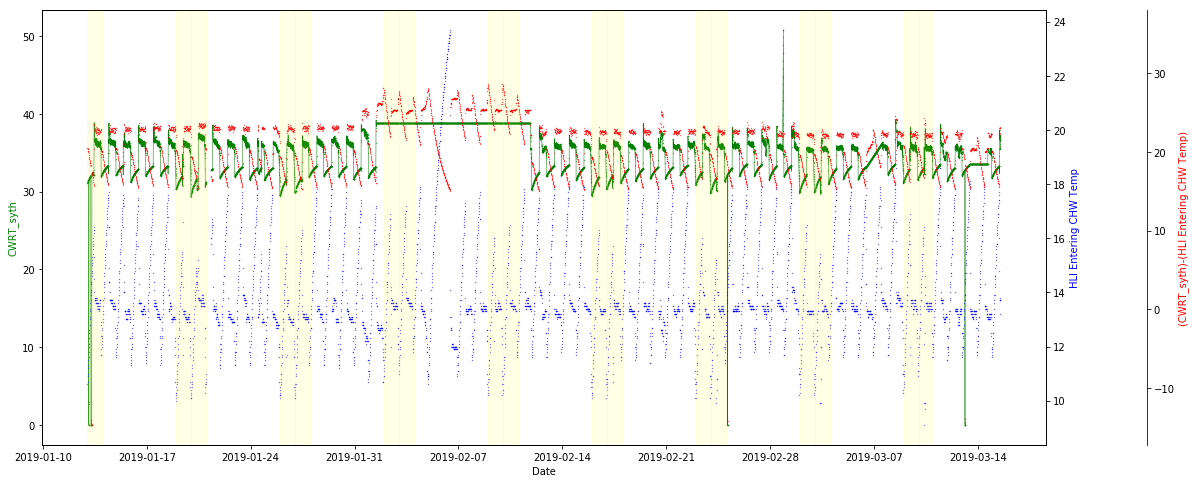

In [6]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_3.index, data_3[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_3.index.to_frame()
tmp['wkday'] = data_3.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


#### data_2_impute

In [7]:
data_2_impute = pd.read_csv(rootPath+'data_2_impute.csv', index_col='Unnamed: 0', date_parser=dateparse)
# create additional features
data_2_impute['(CWRT_syth)-(HLI Entering CHW Temp)'] = data_2_impute['CWRT_syth']-data_2_impute['HLI Entering CHW Temp']

print(data_2_impute.shape)
print(data_2_impute.dtypes)
print(min(data_2_impute.index), max(data_2_impute.index))
display(data_2_impute.head())


(17789, 17)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                 object
LABEL_(HLI Entering CHW Temp)_(wrong_gap)     object
weekday                                        int64
hourminute                                     int64
Score_(CWRT_syth)_distanced                  float64
Score_(HLI Entering CHW Temp)_distanced      float64
Score_(CWRT_syth)_cluster                    float64
Score_(HLI Entering CHW Temp)_cluster        float64
CWRT_syth_leave_empty                           bool
CWRT_syth_fill_median                           bool
HLI Entering CHW Temp_leave_empty               bool
HLI Entering CHW Temp_fill_median               bool
(CWRT_syth)-(HLI Entering CHW Temp)          float64
dtype: object
2019-01-12 21:05:00 2019-03-15 15:25:00


Date Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-12 21:05:00  NaN  NaN  35.709999              13.300000   
2019-01-12 21:10:00  NaN  NaN  35.641001              13.200000   
2019-01-12 21:15:00  NaN  NaN  35.536000              12.983333   
2019-01-12 21:20:00  NaN  NaN  35.425000              12.766667   
2019-01-12 21:25:00  NaN  NaN  35.328000              12.550000   

                    LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-12 21:05:00                           NaN   
2019-01-12 21:10:00                           NaN   
2019-01-12 21:15:00                           NaN   
2019-01-12 21:20:00                           NaN   
2019-01-12 21:25:00                           NaN   

                    LABEL_(HLI Entering CHW Temp)_(wrong_gap)  weekday  \
2019-01-12 21:05:00                                       NaN        6   
2019-01-12 21:10:00                                       NaN        6   
2019-01-12 21:15:00                                       NaN        6   
2019-01-12 21:20:00                                       NaN        6   
2019-01-12 21:25:00                                       NaN        6   

                     hourminute  Score_(CWRT_syth)_distanced  \
2019-01-12 21:05:00        1265                          NaN   
2019-01-12 21:10:00        1270                          NaN   
2019-01-12 21:15:00        1275                          NaN   
2019-01-12 21:20:00        1280                          NaN   
2019-01-12 21:25:00        1285                          NaN   

                     Score_(HLI Entering CHW Temp)_distanced  \
2019-01-12 21:05:00                                      NaN   
2019-01-12 21:10:00                                      NaN   
2019-01-12 21:15:00                                      NaN   
2019-01-12 21:20:00                                      NaN   
2019-01-12 21:25:00                                      NaN   

                     Score_(CWRT_syth)_cluster  \
2019-01-12 21:05:00                        NaN   
2019-01-12 21:10:00                        NaN   
2019-01-12 21:15:00                        NaN   
2019-01-12 21:20:00                        NaN   
2019-01-12 21:25:00                        NaN   

                     Score_(HLI Entering CHW Temp)_cluster  \
2019-01-12 21:05:00                                    NaN   
2019-01-12 21:10:00                                    NaN   
2019-01-12 21:15:00                                    NaN   
2019-01-12 21:20:00                                    NaN   
2019-01-12 21:25:00                                    NaN   

                     CWRT_syth_leave_empty  CWRT_syth_fill_median  \
2019-01-12 21:05:00                  False                   True   
2019-01-12 21:10:00                  False                   True   
2019-01-12 21:15:00                  False                   True   
2019-01-12 21:20:00                  False                   True   
2019-01-12 21:25:00                  False                   True   

                     HLI Entering CHW Temp_leave_empty  \
2019-01-12 21:05:00                              False   
2019-01-12 21:10:00                              False   
2019-01-12 21:15:00                              False   
2019-01-12 21:20:00                              False   
2019-01-12 21:25:00                              False   

                     HLI Entering CHW Temp_fill_median  \
2019-01-12 21:05:00                               True   
2019-01-12 21:10:00                               True   
2019-01-12 21:15:00                               True   
2019-01-12 21:20:00                               True   
2019-01-12 21:25:00                               True   

                     (CWRT_syth)-(HLI Entering CHW Temp)  
2019-01-12 21:05:00                            22.409999  
2019-01-12 21:10:00                            22.441001  
2019-01-12 21:15:00                            22.552667  
2019-01-12 21:20:00                            22.658333  
2

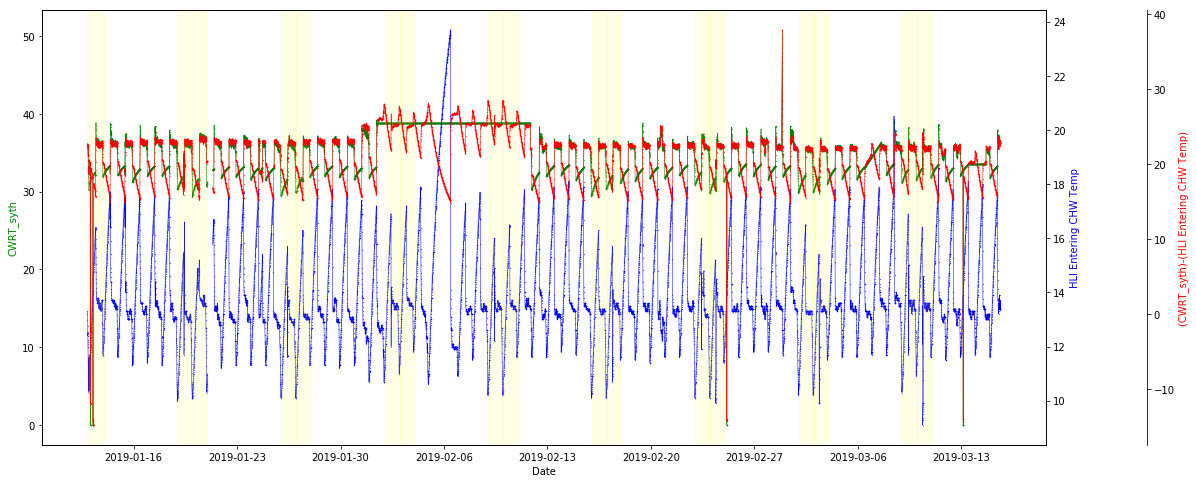

In [8]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_2_impute.index, data_2_impute[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


## Prophet model

In [9]:
def normalize_scores(pds_):
    pds = pds_.copy()
    pds_max = pds.max()
    pds_min = pds.min()
    return 100*(pds - pds_min).div(pds_max - pds_min)    

In [10]:
col = 'HLI Entering CHW Temp'

### <font color=grey>Prophet:</font> <font color=blue>col = 'HLI Entering CHW Temp'</font>

In [11]:
interval_width = 0.99
changepoint_range = 0.8
tmp = data_2_clean[col].to_frame().copy()
tmp.reset_index(inplace=True)
tmp.columns=['ds', 'y']

tmp2 = data_2_impute[col].to_frame().copy()
tmp2.reset_index(inplace=True)
tmp2.columns=['ds', 'y']

model0 = fbprophet.Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
model0.fit(tmp)

colnamelist = [col+'_pred', col+'_pred_lower', col+'_pred_upper']
pred0_cleaned = model0.predict(tmp)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
pred0_cleaned.index.name = None
pred0_cleaned.columns = colnamelist
data_2_clean = pd.concat([data_2_clean, pred0_cleaned], axis=1)
data_2_clean['Score_('+col+')_fb'] = normalize_scores(abs(data_2_clean[col]-data_2_clean[col+'_pred']))
display(data_2_clean.head())

pred0_uncleaned = model0.predict(tmp2)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
pred0_uncleaned.index.name = None
pred0_uncleaned.columns = colnamelist
data_2_impute = pd.concat([data_2_impute, pred0_uncleaned], axis=1)
data_2_impute['Score_('+col+')_fb'] = normalize_scores(abs(data_2_impute[col]-data_2_impute[col+'_pred']))
display(data_2_impute.head())


data_3 = data_3.merge(pred0_uncleaned, how='left', left_on=data_3.index, 
                      right_on=pred0_uncleaned.index).set_index('key_0')
data_3.index.name = None
data_3['Score_('+col+')_fb'] = normalize_scores(abs(data_3[col]-data_3[col+'_pred']))
display(data_3.head())


/Users/phuw273g/.conda/envs/untitled/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


CWRT_syth  HLI Entering CHW Temp  weekday  hourminute  \
2019-01-13 00:00:00  30.490000              11.700000        7           0   
2019-01-13 00:05:00  30.506000              11.125000        7           5   
2019-01-13 00:10:00  30.530001              10.600000        7          10   
2019-01-13 00:15:00  30.546000              10.633334        7          15   
2019-01-13 00:20:00  30.590000              10.666667        7          20   

                     (CWRT_syth)-(HLI Entering CHW Temp)  \
2019-01-13 00:00:00                            18.790000   
2019-01-13 00:05:00                            19.381000   
2019-01-13 00:10:00                            19.930000   
2019-01-13 00:15:00                            19.912667   
2019-01-13 00:20:00                            19.923333   

                     HLI Entering CHW Temp_pred  \
2019-01-13 00:00:00                   10.880021   
2019-01-13 00:05:00                   10.910082   
2019-01-13 00:10:00                   10.944618   
2019-01-13 00:15:00                   10.983519   
2019-01-13 00:20:00                   11.026653   

                     HLI Entering CHW Temp_pred_lower  \
2019-01-13 00:00:00                          9.316380   
2019-01-13 00:05:00                          9.386996   
2019-01-13 00:10:00                          9.499383   
2019-01-13 00:15:00                          9.396778   
2019-01-13 00:20:00                          9.423625   

                     HLI Entering CHW Temp_pred_upper  \
2019-01-13 00:00:00                         12.413923   
2019-01-13 00:05:00                         12.599908   
2019-01-13 00:10:00                         12.600709   
2019-01-13 00:15:00                         12.507112   
2019-01-13 00:20:00                         12.669046   

                     Score_(HLI Entering CHW Temp)_fb  
2019-01-13 00:00:00                         14.833914  
2019-01-13 00:05:00                          3.886894  
2019-01-13 00:10:00                          6.233480  
2019-01-13 00:15:00                          6.334215  
2019-01-13 00:20:00                          6.511540

Date Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-12 21:05:00  NaN  NaN  35.709999              13.300000   
2019-01-12 21:10:00  NaN  NaN  35.641001              13.200000   
2019-01-12 21:15:00  NaN  NaN  35.536000              12.983333   
2019-01-12 21:20:00  NaN  NaN  35.425000              12.766667   
2019-01-12 21:25:00  NaN  NaN  35.328000              12.550000   

                    LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-12 21:05:00                           NaN   
2019-01-12 21:10:00                           NaN   
2019-01-12 21:15:00                           NaN   
2019-01-12 21:20:00                           NaN   
2019-01-12 21:25:00                           NaN   

                    LABEL_(HLI Entering CHW Temp)_(wrong_gap)  weekday  \
2019-01-12 21:05:00                                       NaN        6   
2019-01-12 21:10:00                                       NaN        6   
2019-01-12 21:15:00                                       NaN        6   
2019-01-12 21:20:00                                       NaN        6   
2019-01-12 21:25:00                                       NaN        6   

                     hourminute  Score_(CWRT_syth)_distanced  \
2019-01-12 21:05:00        1265                          NaN   
2019-01-12 21:10:00        1270                          NaN   
2019-01-12 21:15:00        1275                          NaN   
2019-01-12 21:20:00        1280                          NaN   
2019-01-12 21:25:00        1285                          NaN   

                     Score_(HLI Entering CHW Temp)_distanced  \
2019-01-12 21:05:00                                      NaN   
2019-01-12 21:10:00                                      NaN   
2019-01-12 21:15:00                                      NaN   
2019-01-12 21:20:00                                      NaN   
2019-01-12 21:25:00                                      NaN   

                     Score_(CWRT_syth)_cluster  \
2019-01-12 21:05:00                        NaN   
2019-01-12 21:10:00                        NaN   
2019-01-12 21:15:00                        NaN   
2019-01-12 21:20:00                        NaN   
2019-01-12 21:25:00                        NaN   

                     Score_(HLI Entering CHW Temp)_cluster  \
2019-01-12 21:05:00                                    NaN   
2019-01-12 21:10:00                                    NaN   
2019-01-12 21:15:00                                    NaN   
2019-01-12 21:20:00                                    NaN   
2019-01-12 21:25:00                                    NaN   

                     CWRT_syth_leave_empty  CWRT_syth_fill_median  \
2019-01-12 21:05:00                  False                   True   
2019-01-12 21:10:00                  False                   True   
2019-01-12 21:15:00                  False                   True   
2019-01-12 21:20:00                  False                   True   
2019-01-12 21:25:00                  False                   True   

                     HLI Entering CHW Temp_leave_empty  \
2019-01-12 21:05:00                              False   
2019-01-12 21:10:00                              False   
2019-01-12 21:15:00                              False   
2019-01-12 21:20:00                              False   
2019-01-12 21:25:00                              False   

                     HLI Entering CHW Temp_fill_median  \
2019-01-12 21:05:00                               True   
2019-01-12 21:10:00                               True   
2019-01-12 21:15:00                               True   
2019-01-12 21:20:00                               True   
2019-01-12 21:25:00                               True   

                     (CWRT_syth)-(HLI Entering CHW Temp)  \
2019-01-12 21:05:00                            22.409999   
2019-01-12 21:10:00                            22.441001   
2019-01-12 21:15:00                            22.552667   
2019-01-12 21:20:00                            22.658333

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  weekday  \
2019-01-13 00:00:00                                      False        7   
2019-01-13 00:05:00                                      False        7   
2019-01-13 00:10:00                                      False        7   
2019-01-13 00:15:00                                      False        7   
2019-01-13 00:20:00                                      False        7   

                     hourminute  Score_(CWRT_syth)_distanced  \
2019-01-13 00:00:00           0                          0.0   
2019-01-13 00:05:00           5                          0.0   
2019-01-13 00:10:00          10                          0.0   
2019-01-13 00:15:00          15                          0.0   
2019-01-13 00:20:00          20                          0.0   

                     Score_(HLI Entering CHW Temp)_distanced  \
2019-01-13 00:00:00                                      NaN   
2019-01-13 00:05:00                                      NaN   
2019-01-13 00:10:00                                      0.0   
2019-01-13 00:15:00                                      NaN   
2019-01-13 00:20:00                                      NaN   

                     Score_(CWRT_syth)_cluster  \
2019-01-13 00:00:00                  27.467759   
2019-01-13 00:05:00                  27.467759   
2019-01-13 00:10:00                  27.467759   
2019-01-13 00:15:00                  27.467759   
2019-01-13 00:20:00                  27.467759   

                     Score_(HLI Entering CHW Temp)_cluster  \
2019-01-13 00:00:00                                2.62796   
2019-01-13 00:05:00                                2.62796   
2019-01-13 00:10:00                                2.62796   
2019-01-13 00:15:00                                2.62796   
2019-01-13 00:20:00                                2.62796   

                     (CWRT_syth)-(HLI Entering CHW Temp)  CWRT_syth_pred  \
2019-01-13 00:00:00                                  NaN       31.078512   
2019-01-13 00:05:00                                  NaN       31.050151   
2019-01-13 00:10:00                            20.529999       31.026189   
2019-01-13 00:15:00                                  NaN       31.006549   
2019-01-13 00:20:00                                  NaN       30.991137   

                     CWRT_syth_pred_lower  CWRT_syth_pred_upper  \
2019-01-13 00:00:00             28.673261             33.290644   
2019-01-13 00:05:00             28.829544             33.309947   
2019-01-13 00:10:00             28.664084             33.169350   
2019-01-13 00:15:00             28.609239             33.432040   
2019-01-13 00:20:00             28.535493             33.063928   

                     Score_(CWRT_syth)_fb  Score_(CWRT_syth)_fb_modified  \
2019-01-13 00:00:00              0.035330                       0.035330   
2019-01-13 00:05:00              0.171865                       0.171865   
2019-01-13 00:10:00              0.319480                       0.319480   
2019-01-13 00:15:00              0.429174                       0.429174   
2019-01-13 00:20:00              0.550475                       0.550475   

                     HLI Entering

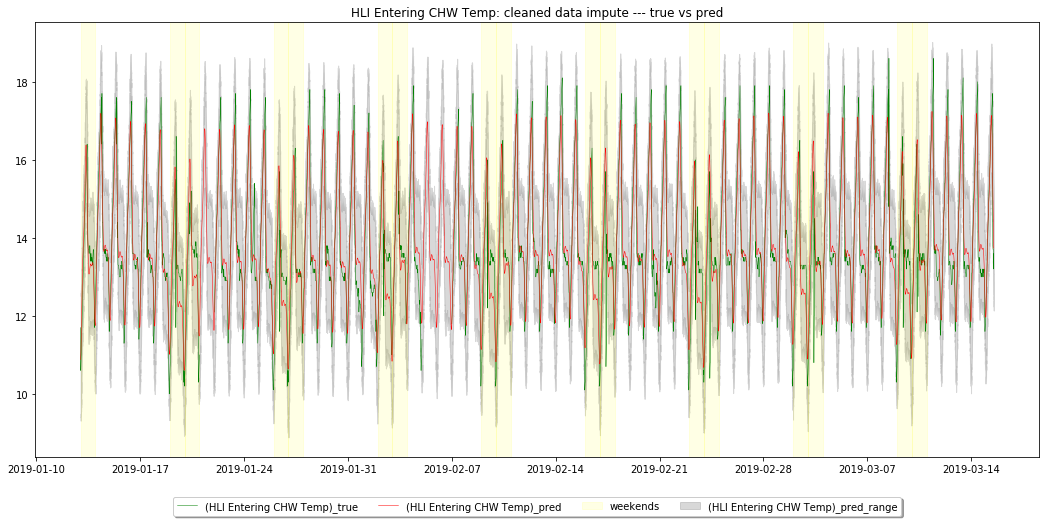

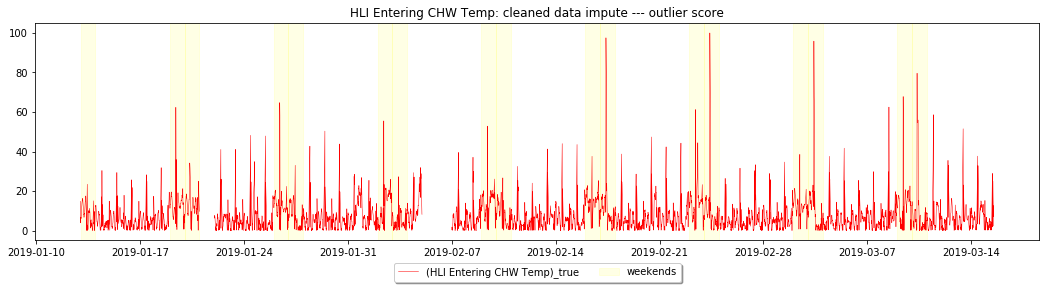

In [12]:
# plot: compare true with pred

#------------------------------
plt.subplots(figsize=(18, 8))
plt.plot_date(data_2_clean.index, data_2_clean[col], 
              c='green',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_true')
plt.plot_date(data_2_clean.index, data_2_clean[col+'_pred'], 
              c='red',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_pred')
plt.fill_between(data_2_clean.index, data_2_clean[col+'_pred_lower'], data_2_clean[col+'_pred_upper'],
                 color='grey', label='('+col+')_pred_range', alpha=0.3)
tmp = data_2_clean.index.to_frame()
tmp['wkday'] = data_2_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': cleaned data impute --- true vs pred')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

#------------------------------
plt.subplots(figsize=(18, 4))

plt.plot_date(data_2_clean.index, data_2_clean['Score_('+col+')_fb'], c='red',  markersize=0.5,  marker='', 
              linewidth=0.5, linestyle='-', label='('+col+')_true')
tmp = data_2_clean.index.to_frame()
tmp['wkday'] = data_2_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': cleaned data impute --- outlier score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()



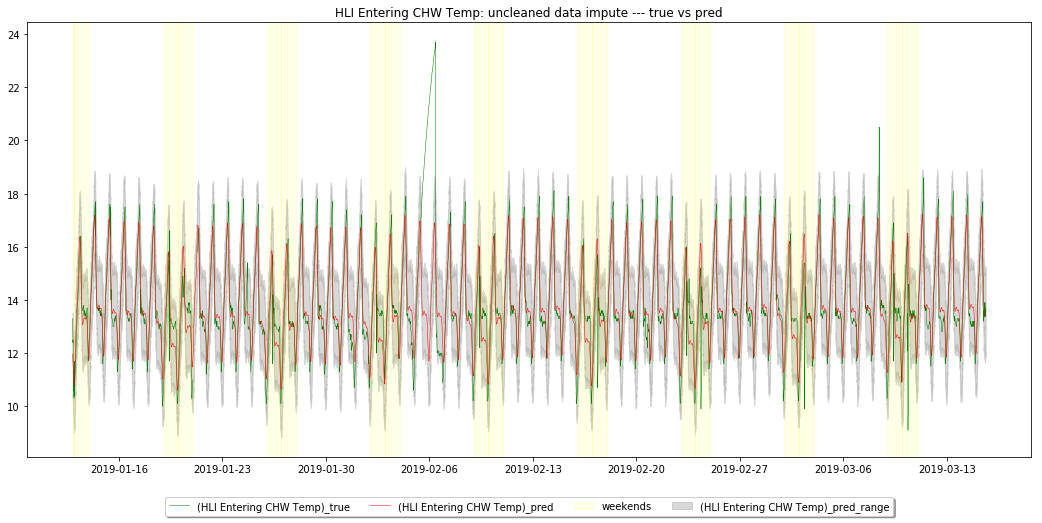

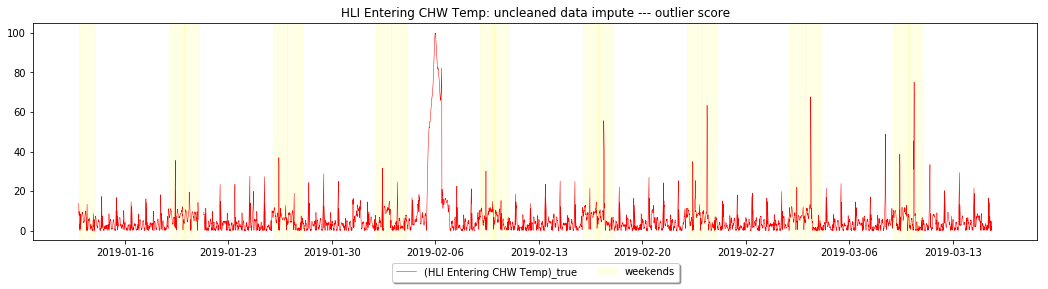

In [13]:
# plot: compare true with pred

#------------------------------
plt.subplots(figsize=(18, 8))
plt.plot_date(data_2_impute.index, data_2_impute[col], 
              c='green',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_true')
plt.plot_date(data_2_impute.index, data_2_impute[col+'_pred'], 
              c='red',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_pred')
plt.fill_between(data_2_impute.index, data_2_impute[col+'_pred_lower'], data_2_impute[col+'_pred_upper'],
                 color='grey', label='('+col+')_pred_range', alpha=0.3)
tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': uncleaned data impute --- true vs pred')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

#------------------------------
plt.subplots(figsize=(18, 4))

plt.plot_date(data_2_impute.index, data_2_impute['Score_('+col+')_fb'], c='red',  markersize=0.5,  marker='', 
              linewidth=0.5, linestyle='-', label='('+col+')_true')
tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': uncleaned data impute --- outlier score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

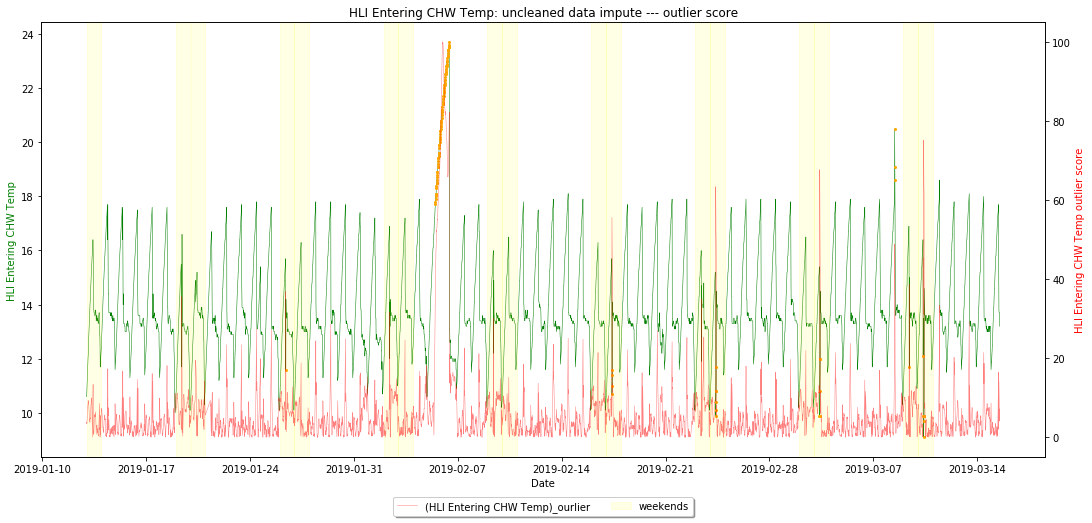

In [14]:
pctoutlier = 0.02

scorecol = 'Score_('+col+')_fb'
df = data_3[[col, col+'_pred', scorecol]].copy()
df = df.dropna(subset=[col])
thrshold = np.nanpercentile(df[scorecol].values, (1-pctoutlier)*100)

# plot: compare true with score
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(df.index, df[col], 
              c='green',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_true')
sub = df.loc[df[scorecol]>thrshold, col].dropna()
ax1.plot_date(sub.index, sub, 
              c='orange',  markersize=4,  marker='.', linewidth=0.5, linestyle='', label='('+col+')_ourlier')
ax1.set_ylabel(col, color='green')
ax1.set_xlabel('Date')

tmp = df.index.to_frame()
tmp['wkday'] = df.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

ax2.plot_date(df.index, df[scorecol], 
              c='red',  markersize=0.5,  marker='', 
              linewidth=0.5, linestyle='-', label='('+col+')_ourlier', alpha=0.5)
ax2.set_ylabel(col+' outlier score', color='red')
ax2.set_xlabel('Date')

plt.title(col+': uncleaned data impute --- outlier score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

In [15]:
#--------------- score iteration 2 --------------------
def getnextscore(df_, scorecol, windowsize, pctoutlier = 0.1):
    df = df_.copy()
    thrshold = np.nanpercentile(df[scorecol].values, (1-pctoutlier)*100)
    df['modified_score'] = df_[scorecol]
    df.loc[df[scorecol]>thrshold, 'modified_score'] = np.nan
    df['modified_score'] = df['modified_score'].rolling(window=windowsize).mean()
    cond = (df['modified_score'].isna())|(df[scorecol]>thrshold)
    df.loc[cond, 'modified_score'] = df.loc[cond, scorecol]
    return df['modified_score']
    

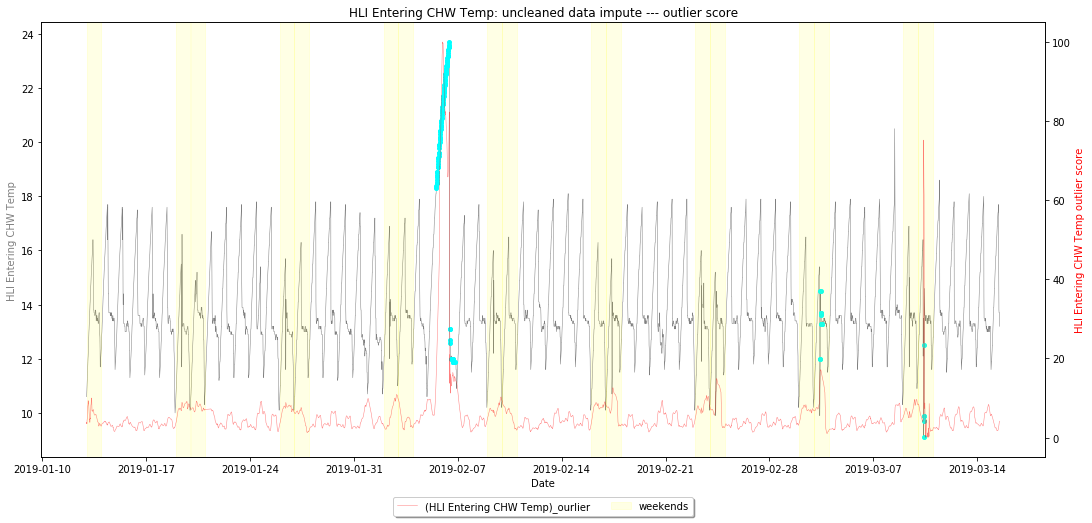

In [17]:
pctoutlier = 0.02  # adjustable !!!!!!!!!!!!!

scorecol = 'Score_('+col+')_fb_modified'
df = data_3[[col, col+'_pred', 'Score_('+col+')_fb']].copy()
df = df.dropna(subset=[col])
df[scorecol] = getnextscore(df, 'Score_('+col+')_fb', int(3*60/5), pctoutlier = 0.01)  # adjustable !!!!!!!!!!

thrshold = np.nanpercentile(df[scorecol].values, (1-pctoutlier)*100)

# plot: compare true with score
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(df.index, df[col], 
              c='grey',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_true')
sub = df.loc[df[scorecol]>thrshold, col].dropna()
ax1.plot_date(sub.index, sub, 
              c='cyan',  markersize=8,  marker='.', linewidth=0.5, linestyle='', label='('+col+')_ourlier')
ax1.set_ylabel(col, color='grey')
ax1.set_xlabel('Date')

tmp = df.index.to_frame()
tmp['wkday'] = df.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

ax2.plot_date(df.index, df[scorecol], 
              c='red',  markersize=0.5,  marker='', 
              linewidth=0.5, linestyle='-', label='('+col+')_ourlier', alpha=0.5)
ax2.set_ylabel(col+' outlier score', color='red')
ax2.set_xlabel('Date')

plt.title(col+': uncleaned data impute --- outlier score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

In [18]:
try:
    data_3 = data_3.drop(scorecol, axis=1)
except:
    pass

data_3 = pd.concat([data_3, df[scorecol]], axis=1)
data_3.head()

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  weekday  \
2019-01-13 00:00:00                                      False        7   
2019-01-13 00:05:00                                      False        7   
2019-01-13 00:10:00                                      False        7   
2019-01-13 00:15:00                                      False        7   
2019-01-13 00:20:00                                      False        7   

                     hourminute  Score_(CWRT_syth)_distanced  \
2019-01-13 00:00:00           0                          0.0   
2019-01-13 00:05:00           5                          0.0   
2019-01-13 00:10:00          10                          0.0   
2019-01-13 00:15:00          15                          0.0   
2019-01-13 00:20:00          20                          0.0   

                     Score_(HLI Entering CHW Temp)_distanced  \
2019-01-13 00:00:00                                      NaN   
2019-01-13 00:05:00                                      NaN   
2019-01-13 00:10:00                                      0.0   
2019-01-13 00:15:00                                      NaN   
2019-01-13 00:20:00                                      NaN   

                     Score_(CWRT_syth)_cluster  \
2019-01-13 00:00:00                  27.467759   
2019-01-13 00:05:00                  27.467759   
2019-01-13 00:10:00                  27.467759   
2019-01-13 00:15:00                  27.467759   
2019-01-13 00:20:00                  27.467759   

                     Score_(HLI Entering CHW Temp)_cluster  \
2019-01-13 00:00:00                                2.62796   
2019-01-13 00:05:00                                2.62796   
2019-01-13 00:10:00                                2.62796   
2019-01-13 00:15:00                                2.62796   
2019-01-13 00:20:00                                2.62796   

                     (CWRT_syth)-(HLI Entering CHW Temp)  CWRT_syth_pred  \
2019-01-13 00:00:00                                  NaN       31.078512   
2019-01-13 00:05:00                                  NaN       31.050151   
2019-01-13 00:10:00                            20.529999       31.026189   
2019-01-13 00:15:00                                  NaN       31.006549   
2019-01-13 00:20:00                                  NaN       30.991137   

                     CWRT_syth_pred_lower  CWRT_syth_pred_upper  \
2019-01-13 00:00:00             28.673261             33.290644   
2019-01-13 00:05:00             28.829544             33.309947   
2019-01-13 00:10:00             28.664084             33.169350   
2019-01-13 00:15:00             28.609239             33.432040   
2019-01-13 00:20:00             28.535493             33.063928   

                     Score_(CWRT_syth)_fb  Score_(CWRT_syth)_fb_modified  \
2019-01-13 00:00:00              0.035330                       0.035330   
2019-01-13 00:05:00              0.171865                       0.171865   
2019-01-13 00:10:00              0.319480                       0.319480   
2019-01-13 00:15:00              0.429174                       0.429174   
2019-01-13 00:20:00              0.550475                       0.550475   

                     HLI Entering

In [19]:
data_3.to_csv('data_3_prophet.csv', index=True)